In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import re
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import pylab 

In [4]:
import sys
import os
import pickle
sys.path.append(os.path.abspath(os.path.join("../")))
sys.path.append(os.path.abspath(os.path.join("../", "lib", "pysgmcmc/")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
# import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Training model
from lib.utils.misc import *
from lib.utils.env_helpers import get_env
from models.continual_training_dyn import TrainingDynamics
from lib.utils.rllab_env_rollout import IterativeData

/home/thobotics/anaconda2/envs/tf14/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
## https://jonchar.net/notebooks/matplotlib-styling/
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

In [6]:

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [7]:
old_trajectories, new_trajectories = pickle.load(open("./NIPS_DiffDrive_Traj.pkl", "rb"))

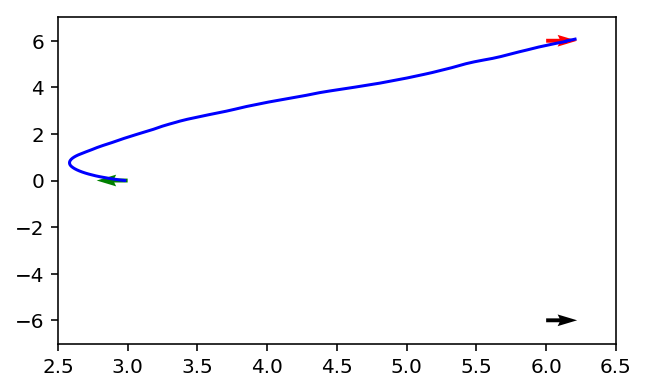

In [9]:
pylab.rcParams['figure.figsize'] = (5, 3)
fig = pylab.figure()

pylab.xlim([2.5, 6.5])
pylab.ylim([-7.0, 7.0])

arrows = [np.array([3.0, 0.0, np.pi]), np.array([6.0, -6.0, 0.0]), np.array([6.0, 6.0, 0.0])]
colors = ['green', 'black', 'red']

for pos, color in zip(arrows, colors):
    pylab.quiver(pos[0], pos[1],
               np.cos(pos[2]), np.sin(pos[2]), width=0.007,
               color=color, alpha=1.0)
    
# plt.plot(old_trajectories[0, 0, :, 0], old_trajectories[0, 0, :, 1], color="gray", alpha=0.5)
pylab.plot(new_trajectories[0, 0, :, 0], new_trajectories[0, 0, :, 1], color="blue")

# pylab.grid()
pylab.show()

fig.savefig('NIPS_Toy_DiffDrive.png', dpi=300, bbox_inches='tight', transparent=False)

In [ ]:
old_trajectories = np.copy(trajectories)

In [ ]:
pickle.dump((old_trajectories, new_trajectories), open("./NIPS_DiffDrive_Traj.pkl", "wb"))

In [ ]:
from policy.nn_policy import NNPolicy
# from policy.nn_lstm_policy import NNPolicy

# root_dir = "../results/nips/toydomain/switching_lstm/continual_bnn_trpo/1"
root_dir = "../results/nips/toydomain/origin_mlp/continual_bnn_trpo/0"
params_dir = "%s/params.json" % root_dir

In [ ]:
all_params = load_params(params_dir)
# dump_params(all_params, output_dir)

env = get_env(all_params["env"])
n_states = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
n_inputs = env.observation_space.shape[0] + env.action_space.shape[0]
n_outputs = env.observation_space.shape[0]
n_timestep = all_params["n_timestep"]
n_training = all_params["sample_train_size"]
n_validate = all_params["sample_valid_size"]

In [ ]:
import logging
logger = logging.getLogger()
# logger.setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [ ]:
data_generator = IterativeData(n_states, n_actions, n_timestep,
                                   n_training=n_training, n_validate=n_validate,
                                   rollout_params=all_params["rollout_params"])

In [ ]:
xu_training, y_training, xu_validate, y_validate = pickle.load(open("%s/rollout.pkl"
                                                                            % root_dir, "rb"))
data_generator.set_offline(xu_training, y_training, xu_validate, y_validate)

In [ ]:
training = TrainingDynamics(n_inputs, n_outputs, n_timestep,
                                action_bounds=env.action_space.bounds, session=sess,
                                model_type=all_params["model"],
                                dynamic_params=all_params["dynamics_params"],
                                dynamic_opt_params=all_params["dynamics_opt_params"])

In [ ]:
training.add_data(xu_training[:, :n_states], xu_training[:, n_states:], y_training)

In [ ]:
training.restore(root_dir)

In [ ]:
nn_policy = NNPolicy(sess, env, training, n_timestep, n_states, n_actions,
                         log_dir=root_dir,
                         policy_params=all_params["policy_params"],
                         policy_opt_params=all_params["policy_opt_params"])

In [ ]:
nn_policy.policy_saver.restore(sess, os.path.join(root_dir, 'policy.ckpt'))
# nn_policy.policy_saver.restore(sess, os.path.join("../results/nips/toydomain/switching_mlp/continual_bnn_trpo/0", 'policy.ckpt'))
# nn_policy.policy_saver.restore(sess, os.path.join("../results/nips/toydomain/origin_mlp/continual_bnn_trpo/0", 'policy.ckpt'))

In [ ]:
from lib.utils.env_helpers import *

In [ ]:
inits = nn_policy.policy_validation_init[:1]
trajectories = np.zeros((training.model.n_nets, len(inits), n_timestep, n_states))
real_trajectories = np.zeros((training.model.n_nets, len(inits), n_timestep, n_states))
envs = [pickle.loads(pickle.dumps(env)) for _ in range(len(inits))]
observations = reset_batch(envs, inits)

for i in range(training.model.n_nets):

    dones = np.asarray([True] * len(inits))

    x = inits
    _policy_cost = 0
    nn_policy.training_policy.reset(dones)
    observations = reset_batch(envs, inits)

    for t in range(n_timestep):
        u = np.clip(nn_policy.session_policy_out(x, stochastic=1.0), *nn_policy.env.action_space.bounds)

        x_next, _ = training.predict(np.concatenate([x, u], axis=1),
                                     return_individual_predictions=True,
                                     model_idx=i)
        x_real_next, _, _, _ = step_batch(envs, u)
        
        trajectories[i, :, t, :] = x_next
        real_trajectories[i, :, t, :] = x_real_next

        # Move forward 1 step.
        x = x_next

In [ ]:
np.sum((trajectories - real_trajectories)**2)

In [ ]:
""" Plot trajectories """

minx = max(np.min(trajectories[:, :, :, 0]) - 0.5, -10.0)
maxx = min(np.max(trajectories[:, :, :, 0]) + 0.5, 10.0)
miny = max(np.min(trajectories[:, :, :, 1]) - 0.5, -10.0)
maxy = min(np.max(trajectories[:, :, :, 1]) + 0.5, 10.0)

plt.rcParams['figure.figsize'] = (8, 3)

for i in range(trajectories.shape[0]):
    fig = plt.figure()

    plt.xlim([minx, maxx])
    plt.ylim([miny, maxy])

    color = ['green', 'k', 'yellow', 'cyan', "blue"]
    color_idx = 0

#     for n in range(trajectories.shape[1]):
    for n in range(1):
#         plt.quiver(trajectories[i, n, :, 0], trajectories[i, n, :, 1],
#                    np.cos(trajectories[i, n, :, 2]), np.sin(trajectories[i, n, :, 2]), width=0.002,
#                    color="blue", alpha=1.0)
# #         color_idx = (color_idx + 1) % len(color)
        
#         plt.quiver(real_trajectories[i, n, :, 0], real_trajectories[i, n, :, 1],
#                    np.cos(real_trajectories[i, n, :, 2]), np.sin(real_trajectories[i, n, :, 2]), width=0.002,
#                    color="black", alpha=1.0)
        plt.plot(trajectories[i, n, :, 0], trajectories[i, n, :, 1], color="blue")
        plt.plot(real_trajectories[i, n, :, 0], real_trajectories[i, n, :, 1], color="black")
#         color_idx = (color_idx + 1) % len(color)

    plt.grid()
    plt.show()

#     if data_path is None:
#         plt.grid()
#         plt.show()
#     else:
#         fig.savefig("%s_m%02d.jpg" % (data_path, i))
#         logging.debug("Saved trajectories")

    plt.close()